In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [16]:
####################################################  Defining Functions  #######################################################

def get_pred_value(i, j):
    ratings = []
    similar = []
    for k in range(0, 1682):
        if((ua_base[i][k]!=0) & (k!=j)):
            ratings.append(ua_base[i][k])
            similar.append(sim[k][j])
    similar, ratings = (list(t) for t in zip(*sorted(zip(similar, ratings))))
    similar.reverse()
    ratings.reverse()
    return ratings, similar

def get_user_rmse(pred):
    user_rmse = [0]*943
    user_count = [0]*943
    for user in range(0,943):
        total = 0
        count = 0
        for rat in range(0,1682):
            if(pred[user][rat]!=0):
                count = count + 1
                total += (pred[user][rat]-ua_test[user][rat]) * (pred[user][rat]-ua_test[user][rat])
        if(count!=0):
            user_rmse[user] = total
            user_count[user] = count
    return user_rmse,user_count

def get_plotting(user_avg_rating, user_rmse, user_count):
    plotting = [0]*5
    for i in range(0,5):
        total_rmse = 0
        count_rmse = 0
        for j in range(0,943):
            if((user_avg_rating[j]>=bins[i]) & (user_avg_rating[j]<bins[i+1])):
                total_rmse += user_rmse[j]
                count_rmse = count_rmse + user_count[j]
        plotting[i] = (float)(total_rmse) / (float)(count_rmse)
    return plotting

def getSimForK(k, ua_test, total_ct):
    predict = np.zeros((943, 1682), dtype=np.int)
    numerator = 0
    for i in range(0, 943):
        for j in range(0, 1682):
            if(ua_test[i][j]!=0):
                ratings, similar = get_pred_value(i, j)
                num = 0
                denom = 0
                for t in range(0, k):
                    num += (ratings[t]*similar[t])
                    denom+= similar[t]
                if(denom!=0):
                    predict[i][j] = num/denom
                numerator+= (ua_test[i][j]- predict[i][j])**2
    err = float(numerator/total_ct)
    rmse = math.sqrt(err)
    return predict, rmse

In [3]:
#################################################  Part 1: Plotting Histograms ##################################################

In [4]:
#################################################  Preprocessing the matrices  ##################################################

col_names = ['userid', 'itemid', 'rating', 'timestamp']

#reading u_data
u_df = pd.read_csv("data/u.data", sep='\t', header = None, names = col_names)
u_df['item_freq'] = u_df.groupby('itemid')['itemid'].transform('count')
u_df['user_freq'] = u_df.groupby('userid')['userid'].transform('count')

u_data = np.zeros((943, 1682), dtype=np.int)
hist1 = np.zeros(1682, dtype=np.int)
hist2 = np.zeros(943, dtype=np.int)

#preprocess matrix
for row in u_df.itertuples():
    u_data[getattr(row, "userid")-1][getattr(row, "itemid")-1] = getattr(row, "rating")
    hist1[getattr(row, "itemid")-1] = getattr(row, "item_freq")
    hist2[getattr(row, "userid")-1] = getattr(row, "user_freq")

Histogram of number of ratings for a movie (10 Bins)


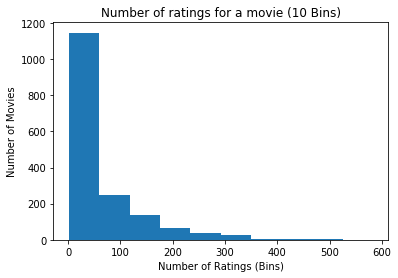

In [23]:
#################################### Histogram of number of ratings for a movie  ################################################

print ("Histogram of number of ratings for a movie (10 Bins)")
plt.hist(hist1, bins=10)
plt.title("Number of ratings for a movie (10 Bins)")
plt.xlabel("Number of Ratings (Bins)")
plt.ylabel("Number of Movies")
plt.show()

Histogram of number of ratings by a user (10 Bins)


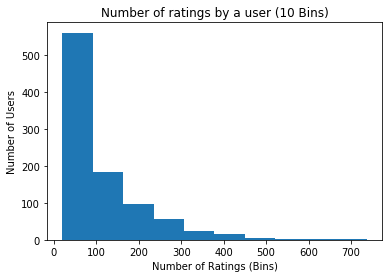

In [22]:
#################################### Histogram of number of ratings by a user  ##################################################

print ("Histogram of number of ratings by a user (10 Bins)")
plt.hist(hist2, bins=10)
plt.title("Number of ratings by a user (10 Bins)")
plt.xlabel("Number of Ratings (Bins)")
plt.ylabel("Number of Users")
plt.show()

In [7]:
#################################################  Part 2: Building Baseline Predictor  #########################################

In [8]:
################################################  Reading in Dataset  ###########################################################

ua_df = pd.read_csv("data/ua.base", sep='\t', header = None, names = col_names)
ua_base = np.zeros((943, 1682), dtype=np.int)
for row in ua_df.itertuples():
    ua_base[getattr(row, "userid")-1][getattr(row, "itemid")-1] = getattr(row, "rating")

ua_test_df = pd.read_csv("data/ua.test", sep='\t', header = None, names = col_names)
ua_test = np.zeros((943, 1682), dtype=np.int)
for row in ua_test_df.itertuples():
    ua_test[getattr(row, "userid")-1][getattr(row, "itemid")-1] = getattr(row, "rating")

In [9]:
########################################  Estimating mu, b_u, b_i and mse  ######################################################

b_i = np.zeros(1682, dtype = np.float)
b_u = np.zeros(943, dtype = np.float)

tot = 0
mu = 0
count = 0
lamda2 = 25 
lamda3 = 10

#calculating mu
for i in range(0, 943):
    for j in range(0, 1682):
        if(ua_base[i][j] !=0):
            count= count+1
            tot+=ua_base[i][j]
mu = float(tot/count)
print ("mu is: ", mu)
print ("")

#calculating b_i
for i in range(0, 1682):
    r_i = 0
    num = 0;
    for j in range(0, 943):
        if(ua_base[j][i]!=0):
            num = num+ (ua_base[j][i]- mu)
            r_i = r_i+1
    b_i[i] =float((num)/(r_i+ lamda2))
print ("b_i is: ", b_i)
print ("")

#calculating b_u
for i in range(0, 943):
    r_u = 0
    num = 0;
    for j in range(0, 1682):
        if(ua_base[i][j]!=0):
            num = num+ (ua_base[i][j]- mu - b_i[j])
            r_u = r_u+1
    b_u[i] = float((num)/(r_u+ lamda3))  
print ("b_u is: ", b_u)
print ("")

total_ct = 0
numerator = 0

#applying baseline prediction to find error
pred = np.zeros((943,1682),dtype=np.float)
for i in range(0, 943):
    for j in range(0, 1682):
        if(ua_test[i][j]!=0):
            total_ct = total_ct+1
            val = mu + b_u[i] + b_i[j]
            pred[i][j] = val
            numerator = numerator + ((val - ua_test[i][j])**2)
err = float(numerator/total_ct)
rmse = math.sqrt(err)
print ("Rmse for baseline predictor is: ", rmse)
print ("")

mu is:  3.5238268742409184

b_i is:  [ 0.31573109 -0.26974693 -0.35932077 ..., -0.05860873 -0.02014719
 -0.02014719]

b_u is:  [  3.26864277e-02   8.64060732e-02  -4.02616257e-01   5.44404006e-01
  -4.75947061e-01  -1.47669361e-01   3.86616283e-01   2.16698233e-01
   2.56949313e-01   4.06455020e-01  -9.09755207e-02   4.45693890e-01
  -3.68535638e-01   3.01317599e-01  -4.29056722e-01   6.00051340e-01
  -2.75261762e-01   1.32911185e-01   2.37070311e-02  -3.34028566e-01
  -5.57284723e-01  -8.23048685e-02  -5.60251003e-02   5.21022016e-01
   1.41749784e-01  -4.63826674e-01  -1.09868252e-01   1.27608827e-01
   1.87175806e-01   2.30957095e-01   1.48405194e-01  -2.05877041e-01
   2.43640648e-01   2.57593283e-01  -1.14740109e-01   4.13211601e-01
   1.37581748e-01   3.55743506e-01   1.60795032e-01  -5.23970461e-01
  -3.69065662e-02   1.39211190e-01   1.44296283e-01  -2.57873595e-02
   1.88189813e-01   2.99548345e-01   6.72333297e-02  -6.22197456e-02
  -7.40510949e-01   5.14245941e-02  -1.539955

In [10]:
#################################  Calculate User Average Rating & Item Average Rating ##########################################

user_avg_rating = [0]*943
for i in range(0,943):
    count = 0
    total=0
    for j in range(0,1682):
        if(ua_base[i][j]!=0):
            count=count+1
            total+=ua_base[i][j]
    user_avg_rating[i]=total/count

hist,bins = np.histogram(user_avg_rating,bins=5)
bin1 = [0]*5
for i in range(0,len(bins)-1):
    bin1[i] = (float)(bins[i]+bins[i+1]) / 2.0
    
avg_item_rating = [0] * 1682
for j in range (0, 1682):
    count = 0;
    total = 0;
    for i in range(0, 943):
        if(ua_base[i][j]!=0):
            count = count + 1
            total +=ua_base[i][j]
    if(count!=0):
        avg_item_rating[j] = float(total/count)

Plotting RMSE per user


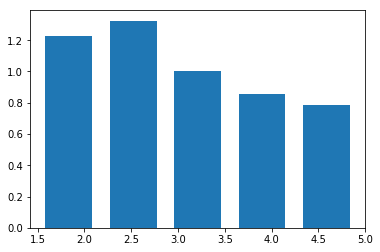

In [21]:
################################################  Plotting RMSE per user  #######################################################

print ("Plotting RMSE per user")
user_rmse, user_count = get_user_rmse(pred)
plotting = get_plotting(user_avg_rating, user_rmse, user_count)
plt.bar(bin1,plotting,width = 0.5)
plt.show()

In [12]:
#########################################  Part 3: Building KNN Based Recommender System  #######################################

In [13]:
#################################################  Finding Similarity Matrix  ###################################################

print ("Finding Similarity matrix")
#create similarity matrix
sim = np.zeros((1682, 1682), dtype = np.float)
for i in range(0, 943):
    #print (i)
    for j in range(0, 1682):
        num = 0
        denom_1 = 0
        denom_2 = 0
        for u in range(0, 943):
            if((ua_base[u][i] !=0 )& (ua_base[u][j]!=0)):
                #proceed
                num += (ua_base[u][i]-avg_item_rating[i])* (ua_base[u][j]-avg_item_rating[j])
                denom_1 += (ua_base[u][i] - avg_item_rating[i])**2
                denom_2 += (ua_base[u][j] - avg_item_rating[j])**2
        if((num!=0)& (denom_1!=0) & (denom_2!=0)):
            sim[i][j] = float(num / (math.sqrt(denom_1) * math.sqrt(denom_2)))

Finding Similarity matrix


In [18]:
###############################################  Computing Test RMSE for each K  ################################################

predict_k_1 = np.zeros((943, 1682), dtype=np.int)
predict_k_2 = np.zeros((943, 1682), dtype=np.int)
predict_k_3 = np.zeros((943, 1682), dtype=np.int)
predict_k_5 = np.zeros((943, 1682), dtype=np.int)
predict_k_10 = np.zeros((943, 1682), dtype=np.int)

print ("k is", 1)
predict_k_1, rmse = getSimForK(1,ua_test, total_ct)
print ("Rmse is: ",rmse)

print ("k is", 2)
predict_k_2, rmse = getSimForK(2,ua_test, total_ct)
print ("Rmse is: ",rmse)

print ("k is", 3)
predict_k_3, rmse = getSimForK(3,ua_test, total_ct)
print ("Rmse is: ",rmse)

print ("k is", 5)
predict_k_5, rmse = getSimForK(5,ua_test, total_ct)
print ("Rmse is: ",rmse)

print ("k is", 10)
predict_k_10, rmse = getSimForK(10,ua_test, total_ct)
print ("Rmse is: ",rmse)

k is 1
Rmse is:  1.4727284033925152
k is 2
Rmse is:  1.4094439838405446
k is 3
Rmse is:  1.356301814839689
k is 5
Rmse is:  1.2937979144666532
k is 10
Rmse is:  1.334110766632895


Plotting RMSE per user for k=1


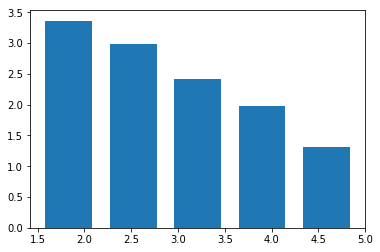

Plotting RMSE per user for k=2


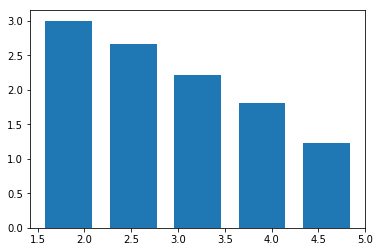

Plotting RMSE per user for k=3


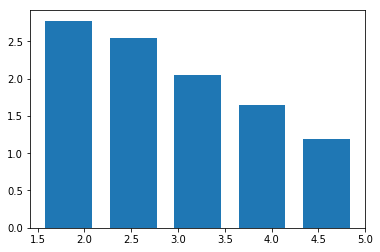

Plotting RMSE per user for k=5


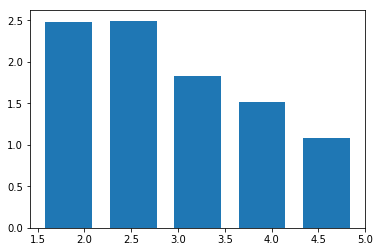

Plotting RMSE per user for k=10


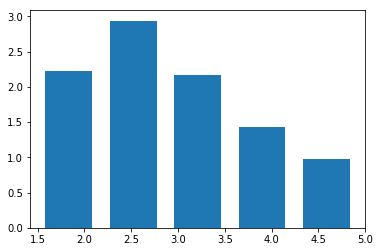

In [20]:
################################################### Plotting RMSE per user  #####################################################

print ("Plotting RMSE per user for k=1")
user_rmse, user_count = get_user_rmse(predict_k_1)
plotting = get_plotting(user_avg_rating, user_rmse, user_count)
plt.bar(bin1,plotting,width = 0.5)
plt.show()

print ("Plotting RMSE per user for k=2")
user_rmse, user_count = get_user_rmse(predict_k_2)
plotting = get_plotting(user_avg_rating, user_rmse, user_count)
plt.bar(bin1,plotting,width = 0.5)
plt.show()

print ("Plotting RMSE per user for k=3")
user_rmse, user_count = get_user_rmse(predict_k_3)
plotting = get_plotting(user_avg_rating, user_rmse, user_count)
plt.bar(bin1,plotting,width = 0.5)
plt.show()

print ("Plotting RMSE per user for k=5")
user_rmse, user_count = get_user_rmse(predict_k_5)
plotting = get_plotting(user_avg_rating, user_rmse, user_count)
plt.bar(bin1,plotting,width = 0.5)
plt.show()

print ("Plotting RMSE per user for k=10")
user_rmse, user_count = get_user_rmse(predict_k_10)
plotting = get_plotting(user_avg_rating, user_rmse, user_count)
plt.bar(bin1,plotting,width = 0.5)
plt.show()

REPORT

This part of the assignment deals with the movielens dataset. I had to build two recommender systems, one using a baseline predictor and the other using KNN with K=5.

First I had to create histograms of number of ratings for a movie. The X-axis denotes the number of ratings that movies have received and the Y-axis denotes the number of movies that have got those ratings. 
Next I had to create histograms of number of ratings by a user. The X-axis denotes the number of ratings given by users and the Y-axis denotes the number of users who gave those ratings. Since, on an average, users don't rate too many movies, the lower bins have higher number of users and that reduces as bins increase.

The baseline recommender system that was built used the values of mu, b_i and b_u that were predicted empirically. The RMSE was then calculated. A plot of RMSE per user was created. The X-axis here denoted range of ratings that were predicted by the system and the Y-axis denoted the total RMSE of all the users who rated within that range. I divided the range of ratings into 5 bins.

The KNN based recommender system that was built used a similarity matrix calculated between similar items. The RMSE was then calculated for different values of k, k=1,2,3,5,10. A plot of RMSE per user was created for each k. The X-axis here denoted range of ratings that were predicted by the system and the Y-axis denoted the total RMSE of all the users who rated within that range. I divided the range of ratings into 5 bins. There are 5 plots for each of the k.